In [1]:
%matplotlib inline


Training an MNIST Classifier
=====
## Custom Dataset, Model Checkpointing, and Fine-tune

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import glob
import os.path as osp
import numpy as np
from PIL import Image

import csv

In [3]:

def readTrainCSV(path):
    with open(path + '/train.csv') as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        fileNames = []
        labels = []
        missingFiles = 0
        for row in readCSV:
            baseName = row[0]
            label = row[2]
            fName = path + '/train/' + baseName + '.jpg'
            if osp.isfile(fName):
                fileNames.append(fName)
                labels.append(label)
            else:
                missingFiles = missingFiles + 1
        print('Found %d missing train files' % missingFiles)
        print('Got %d train picture filenames' % len(fileNames))
        print('Got %d train picture labels' % len(labels))
        return fileNames, labels

def readTestCSV(path):
    with open(path + '/test.csv') as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        fileNames = []
        missingFiles = 0
        for row in readCSV:
            baseName = row[0]
            fName = path + '/test/' + baseName + '.jpg'
            if osp.isfile(fName):
                fileNames.append(fName)
            else:
                missingFiles = missingFiles + 1
        print('Found %d missing test files' % missingFiles)
        print('Got %d test picture filenames' % len(fileNames))
        return fileNames

trainFileNames, labels = readTrainCSV('/home/gangwu/small-landmarks-data')
testFileNames = readTestCSV('/home/gangwu/small-landmarks-data')

Found 9 missing train files
Got 991 train picture filenames
Got 991 train picture labels
Found 5 missing test files
Got 115 test picture filenames



Fetch a small test dataset. Copied 100 images while 5 images are missing:

cp: cannot stat './landmarks-data/landmarks-data/test/00129c981f8e343f.jpg': No such file or directory
cp: cannot stat './landmarks-data/landmarks-data/test/0017d8ef2a3acd3c.jpg': No such file or directory
cp: cannot stat './landmarks-data/landmarks-data/test/0018761e6c424bd4.jpg': No such file or directory
cp: cannot stat './landmarks-data/landmarks-data/test/0019a87e323272b8.jpg': No such file or directory
cp: cannot stat './landmarks-data/landmarks-data/test/003936911178c6f1.jpg': No such file or directory

Fetch a small train dataset. Copied 1000 images while 9 images are missing:

cp: cannot stat './landmarks-data/landmarks-data/train/6e815d2054869066.jpg': No such file or directory
cp: cannot stat './landmarks-data/landmarks-data/train/dd92795296511edb.jpg': No such file or directory
cp: cannot stat './landmarks-data/landmarks-data/train/3aac29d697ccc843.jpg': No such file or directory
cp: cannot stat './landmarks-data/landmarks-data/train/e69d4bbac66a0c96.jpg': No such file or directory
cp: cannot stat './landmarks-data/landmarks-data/train/64dbb4e7d40d93d6.jpg': No such file or directory
cp: cannot stat './landmarks-data/landmarks-data/train/f526fd5146b2b12e.jpg': No such file or directory
cp: cannot stat './landmarks-data/landmarks-data/train/0d9c049e78ba7553.jpg': No such file or directory
cp: cannot stat './landmarks-data/landmarks-data/train/657dece42f5d2dea.jpg': No such file or directory
cp: cannot stat './landmarks-data/landmarks-data/train/84f86ccc809d2d8e.jpg': No such file or directory



## 1. Custom Dataset
PyTorch has many built-in datasets such as MNIST and CIFAR. In this tutorial, we demonstrate how to write your own dataset by implementing a custom MNIST dataset class. Use [this link](https://github.com/myleott/mnist_png/blob/master/mnist_png.tar.gz?raw=true) to download the mnist png dataset.

In [4]:
class LandmarksData(Dataset):
    """
    Data loader for landmarks data.
    """
    def __init__(self,
                 root,
                 transform=None,
                 preload=False,
                 isTrain=False):
        """ Intialize the LandmarksData dataset
        
        Args:
            - root: root directory of the dataset
            - tranform: a custom tranform function
            - preload: if preload the dataset into memory
        """
        self.images = None
        self.labels = None
        self.filenames = []
        self.root = root
        self.transform = transform
        self.isTrain = isTrain

        # read filenames
        if isTrain:
            self.filenames, self.labels = readTrainCSV(self.root)
        else:
            self.filenames = readTestCSV(self.root)
            
        self.filenames = self.filenames[:100]
        
        # if preload dataset into memory
        if preload:
            self._preload()
            
        self.len = len(self.filenames)
                              
    def _preload(self):
        """
        Preload dataset to memory
        """
        #self.labels = []
        self.images = []
        for image_fn in self.filenames:            
            # load images
            image = Image.open(image_fn)
            # avoid too many opened files bug
            self.images.append(image.copy())
            image.close()

    def __getitem__(self, index):
        """ Get a sample from the dataset
        """
        if self.images is not None:
            # If dataset is preloaded
            image = self.images[index]
            if self.isTrain:
                label = self.labels[index]
        else:
            # If on-demand data loading
            image_fn = self.filenames[index]
            image = Image.open(image_fn)
            if self.isTrain:
                label = self.labels[index]
            
        # May use transform function to transform samples
        # e.g., random crop, whitening
        if self.transform is not None:
            image = self.transform(image)
        # return image and label
        return image, label

    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len

In [5]:
# Create the Landmarks dataset. 
# transforms.ToTensor() automatically converts PIL images to
# torch tensors with range [0, 1]

myTrans = transforms.Compose([transforms.Resize((256, 256)),
                              transforms.ToTensor(),
                              #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                             ])

trainset = LandmarksData(
    root='/home/gangwu/small-landmarks-data',
    preload=True, transform=myTrans, isTrain = True
)
# Use the torch dataloader to iterate through the dataset
trainset_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=1)

# load the testset
testset = LandmarksData(
    root='/home/gangwu/small-landmarks-data',
    preload=True, transform=transforms.ToTensor(), isTrain = False
)
# Use the torch dataloader to iterate through the dataset
testset_loader = DataLoader(testset, batch_size=50, shuffle=False, num_workers=1)


Found 9 missing train files
Got 991 train picture filenames
Got 991 train picture labels
Found 5 missing test files
Got 115 test picture filenames


In [6]:
print(len(trainset))
print(len(testset))

100
100


### Visualize the dataset

 6231  9633  7058  1966  3903  2949  8302  6309 12712 12336  6685 10600 10900  9633  9633  2272


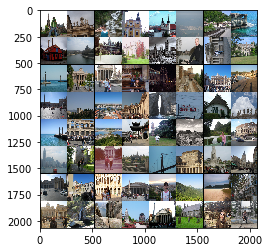

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainset_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j] for j in range(16)))

In [8]:
# Use GPU if available, otherwise stick with cpu
use_cuda = torch.cuda.is_available()
torch.manual_seed(123)
device = torch.device(cuda if use_cuda else "cpu")
print(device)

cpu


### Define a Conv Net


In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### Train the network

In [10]:
def train(epoch, log_interval=100):
    model.train()  # set training mode
    iteration = 0
    for ep in range(epoch):
        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if iteration % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    ep, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
            iteration += 1
        test()

In [11]:
def test():
    model.eval()  # set evaluation mode
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in testset_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(testset_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testset_loader.dataset),
        100. * correct / len(testset_loader.dataset)))

In [12]:
train(5)  # train 5 epochs should get you to about 97% accuracy

AttributeError: 'tuple' object has no attribute 'to'

## 2. Save the model (model checkpointing)

Now we have a model! Obviously we do not want to retrain the model everytime we want to use it. Plus if you are training a super big model, you probably want to save checkpoint periodically so that you can always fall back to the last checkpoint in case something bad happened or you simply want to test models at different training iterations.

Model checkpointing is fairly simple in PyTorch. First, we define a helper function that can save a model to the disk

In [ ]:
def save_checkpoint(checkpoint_path, model, optimizer):
    state = {'state_dict': model.state_dict(),
             'optimizer' : optimizer.state_dict()}
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)

In [ ]:
# create a brand new model
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
test()

### Define a training loop with model checkpointing

In [ ]:
def train_save(epoch, save_interval, log_interval=100):
    model.train()  # set training mode
    iteration = 0
    for ep in range(epoch):
        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if iteration % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    ep, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
            if iteration % save_interval == 0 and iteration > 0:
                save_checkpoint('mnist-%i.pth' % iteration, model, optimizer)
            iteration += 1
        test()
    
    # save the final model
    save_checkpoint('mnist-%i.pth' % iteration, model, optimizer)

In [ ]:
train_save(5, 500, 100)

In [ ]:
# create a new model
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# load from the final checkpoint
load_checkpoint('mnist-4690.pth', model, optimizer)
# should give you the final model accuracy
test()

## 3. Fine-tune a model

Sometimes you want to fine-tune a pretrained model instead of training a model from scratch. For example, if you want to train a model on a new dataset that contains natural images. To achieve the best performance, you can start with a model that's fully trained on ImageNet and fine-tune the model.

Finetuning a model in PyTorch is super easy! First, let's find out what we saved in a checkpoint

In [ ]:
# What's in a state dict?
print(model.state_dict().keys())

### Finetune the fc layers

Now say we want to load the conv layers from the checkpoint and train the fc layers. We can simply load a subset of the state dict with the selected names

In [ ]:
checkpoint = torch.load('mnist-4690.pth')
states_to_load = {}
for name, param in checkpoint['state_dict'].items():
    if name.startswith('conv'):
        states_to_load[name] = param

# Construct a new state dict in which the layers we want
# to import from the checkpoint is update with the parameters
# from the checkpoint
model_state = model.state_dict()
model_state.update(states_to_load)
        
model = Net().to(device)
model.load_state_dict(model_state)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
train(1)  # training 1 epoch will get you to 93%!

### Import pretrained weights in a different model

We can even use the pretrained conv layers in a different model.

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

model = SmallNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
checkpoint = torch.load('mnist-4690.pth')
states_to_load = {}
for name, param in checkpoint['state_dict'].items():
    if name.startswith('conv'):
        states_to_load[name] = param

# Construct a new state dict in which the layers we want
# to import from the checkpoint is update with the parameters
# from the checkpoint
model_state = model.state_dict()
model_state.update(states_to_load)
        
model.load_state_dict(model_state)

In [ ]:
train(1)  # training 1 epoch will get you to 93%!